**MANUELLA KWAWU (UNI: mek2255)**

Importing Packages

In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader


Check GPU Availability

In [2]:
cuda = torch.cuda.is_available()
print(f"GPU is available: {cuda}")

GPU is available: True


Set random seed for reproducibility

In [3]:
torch.manual_seed(1102)
np.random.seed(1102)

Create training, validation and testing dataset

In [5]:
data_root_folder = '../input/singlecellsegmentation/SingleCellSegmentation/'
class BasicDataset(TensorDataset):
    # This function takes folder name ('train', 'valid', 'test') as input and creates an instance of BasicDataset according to that fodler.
    # Also if you'dd like to have less number of samples (for evaluation purposes), you may set the `n_sample` with an integer.
    def __init__(self, folder, n_sample=None):
        self.folder = os.path.join(data_root_folder, folder)
        self.imgs_dir = os.path.join(self.folder, 'image')
        self.masks_dir = os.path.join(self.folder, 'mask')
        
        self.imgs_file = sorted(glob.glob(os.path.join(self.imgs_dir, '*.png')))
        self.masks_file = sorted(glob.glob(os.path.join(self.masks_dir, '*.png')))
        
        assert len(self.imgs_file) == len(self.masks_file), 'There are some missing images or masks in {0}'.format(folder)
        
        # If n_sample is not None (It has been set by the user)
        if not n_sample or n_sample > len(self.imgs_file):
            n_sample = len(self.imgs_file)
        
        self.n_sample = n_sample
        self.ids = list([i+1 for i in range(n_sample)])
            
    # This function returns the lenght of the dataset (AKA number of samples in that set)
    def __len__(self):
        return self.n_sample
    
    
    # This function takes an index (i) which is between 0 to `len(BasicDataset)` (The return of the previous function), then returns RGB image, 
    # mask (Binary), and the index of the file name (Which we will use for visualization). The preprocessing step is also implemented in this function.
    def __getitem__(self, i):
        idx = self.ids[i]
        img = cv2.imread(os.path.join(self.imgs_dir, 'image_{0:04d}.png'.format(idx)), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_dir, 'mask_{0:04d}.png'.format(idx)), cv2.IMREAD_GRAYSCALE)
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #Resize all images from 512 to 256 (H and W)
        img = cv2.resize(img, (256,256))
        mask = cv2.resize(mask, (256,256))
        
        # Scale between 0 to 1
        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0
        
        # Make sure that the mask are binary (0 or 1)
        mask[mask <= 0.5] = 0.0
        mask[mask > 0.5] = 1.0
        
        # Add an axis to the mask array so that it is in [channel, width, height] format.
        mask = np.expand_dims(mask, axis=0)
        
        # HWC to CHW
        img = np.transpose(img, (2, 0, 1))
        
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor),
            'img_id': idx
        }

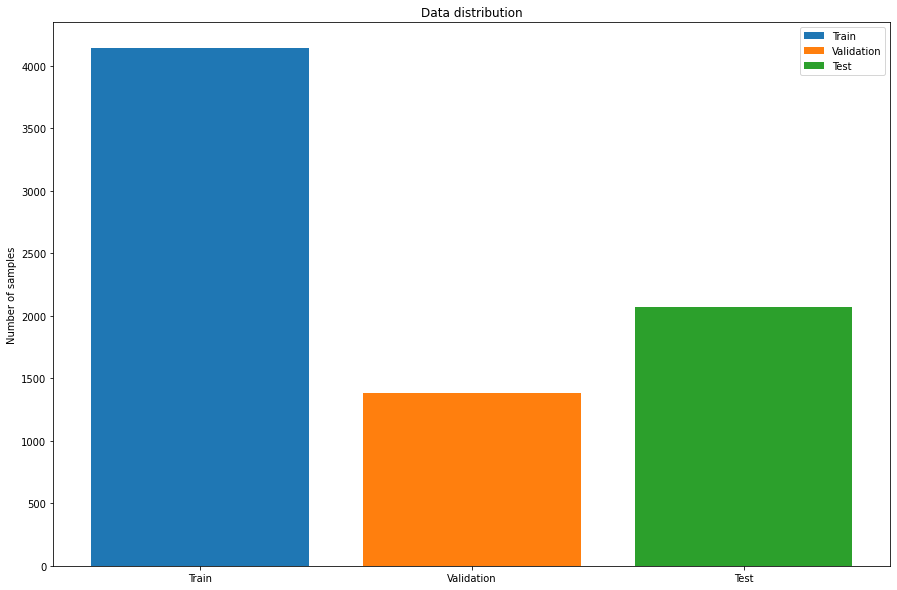

In [6]:
# Create train, validation, and test dataset instances
train_dataset = BasicDataset('train')
valid_dataset = BasicDataset('valid')
test_dataset = BasicDataset('test')

plt.figure(figsize=(15,10))
plt.title('Data distribution')
plt.bar(0, len(train_dataset), label='Train')
plt.bar(1, len(valid_dataset), label='Validation')
plt.bar(2, len(test_dataset), label='Test')
plt.ylabel('Number of samples')
plt.xticks([0,1,2],['Train', 'Validation', 'Test'])
plt.legend()
plt.show()

Display random image and corresponding mask from training dataset

x shape is torch.Size([3, 256, 256])
y shape is torch.Size([1, 256, 256])


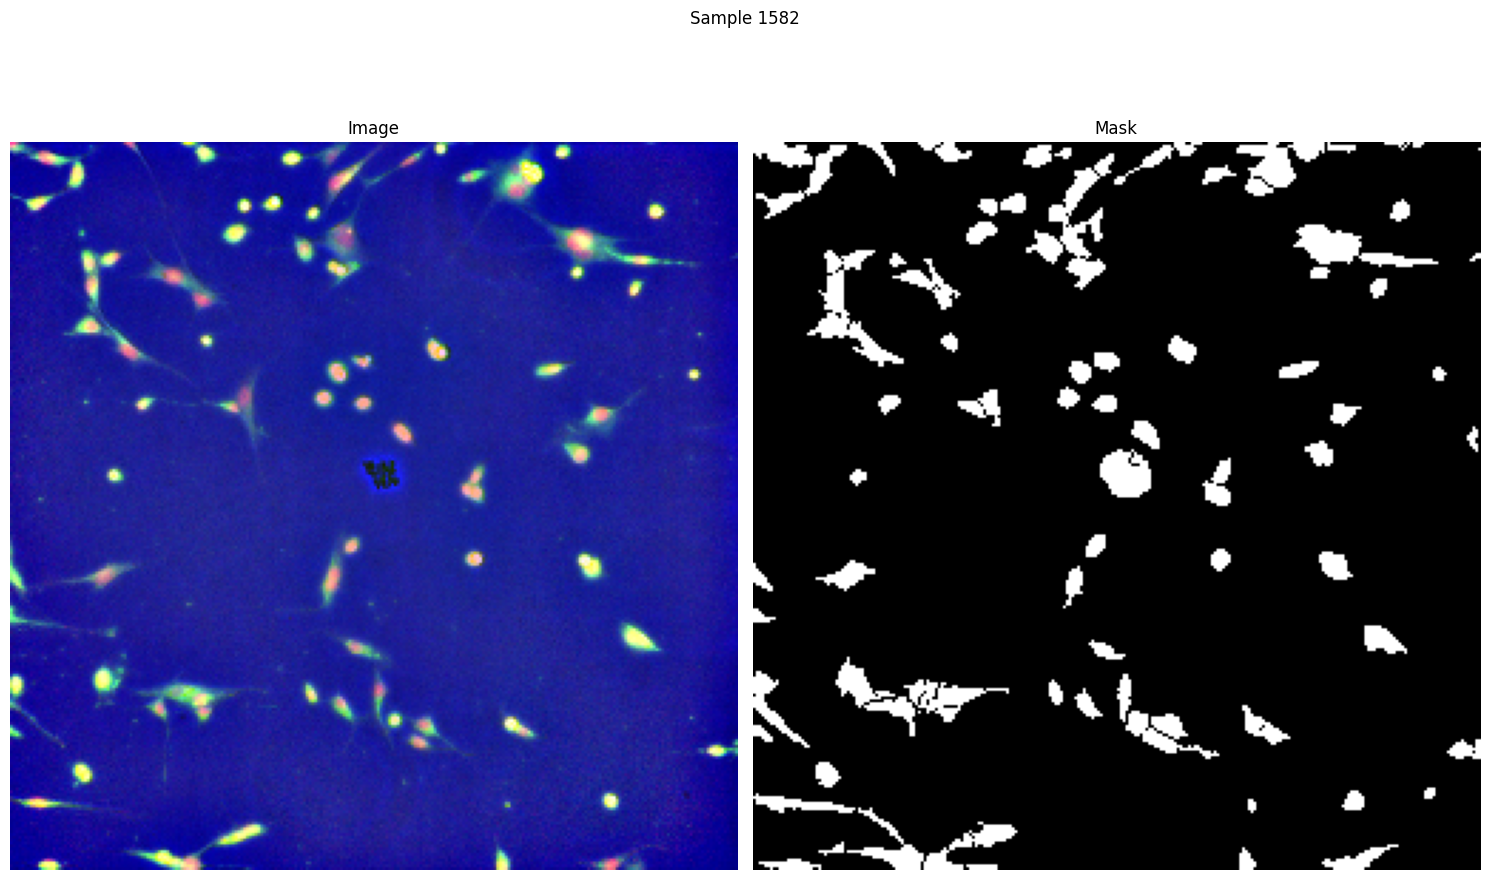

In [7]:
sample = np.random.randint(0, len(train_dataset))
data = train_dataset.__getitem__(sample)
x = data['image']
y = data['mask']
idx = data['img_id']

print(f'x shape is {x.shape}')
print(f'y shape is {y.shape}')

plt.figure(figsize=(15, 10), dpi=100)
plt.suptitle(f'Sample {idx:04d}')
img = np.transpose(x, (1,2,0))
mask = y[0]
plt.subplot(1, 2, 1)
plt.title('Image')
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

Create dataloader for training, validation and testing dataset

In [8]:
train_dataset = BasicDataset('train')
valid_dataset = BasicDataset('valid')
test_dataset = BasicDataset('test')

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=10, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=10, num_workers=2)

Implement U-Net

In [9]:
class DoubleConv(nn.Module):
    """Produces convoluted layers and applies ReLU to the convoluted pixels"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class Down(nn.Module):
    """Uses max pooling to down sample feature maps to produce an updated convoluted layer"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
    
class Up(nn.Module):
    """Uses max unpooling to up sample input and pass it to DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x
    
class OutConv(nn.Module):
    """applies sigmoid activation to a 2D convolution to product the output layer of the U-Net"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)
    
    
    
class UNet(nn.Module):
    def __init__(self, name, n_channels, n_classes):
        super(UNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outputL = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inputL(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        b = self.down4(x4)
        
        x = self.up1(b, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outputL(x)
        
        return x
    
    
my_UNet = UNet('MyUNet', 3, 1)
my_UNet.cuda()

UNet(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

Display test results for non-trained data to show that its predicted mask is far from ground truth.

Sample batch image shape is: torch.Size([10, 3, 256, 256])
Sample batch mask shape is: torch.Size([10, 1, 256, 256])
Predicted mask shape is: torch.Size([10, 1, 256, 256])


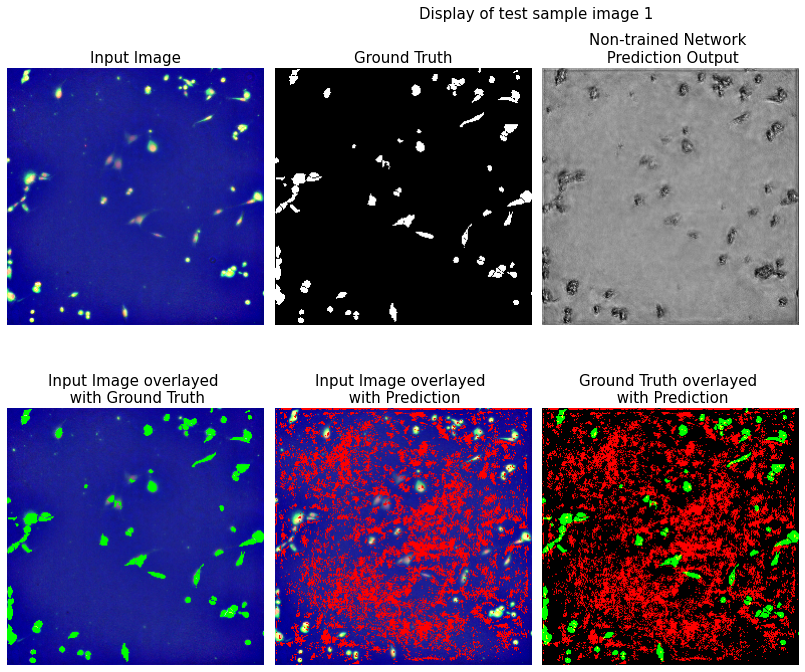

In [11]:

for batch in test_dataloader:
    sample_batch = batch
    break
    
#generate prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# attributes of predicted mask
print("Sample batch image shape is: {0}\nSample batch mask shape is: {1}\nPredicted mask shape is: {2}"
.format(sample_batch['image'].shape, sample_batch['mask'].shape, y_pred.shape ))

# preprocessing
img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')


pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

#image id for display
img_id = sample_batch['img_id'][0]

#display of images
plt.figure(figsize=(15,10))
plt.suptitle(f'Display of test sample image {img_id}', fontsize=15)

#for input image
plt.subplot(2,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img)
plt.axis('off')

#for ground truth 
plt.subplot(2,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

#for predicted output
plt.subplot(2,4,3)
plt.title('Non-trained Network \n Prediction Output', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

#input image compared with ground truth
input_overlayed_GT = img.copy()
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,4,5)
plt.title('Input Image overlayed \n with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

#input image compared with prediction
input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,4,6)
plt.title('Input Image overlayed \n with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

#ground truth compared with image
GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,4,7)
plt.title('Ground Truth overlayed \n with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

Define loss function and optimization method

In [12]:
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.01)
loss_function = nn.BCELoss()

Train model

In [13]:
# Define a function that computes the DICE score for binary segmentation
def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1), y_true.view(-1))
        union = torch.sum(y_pred) + torch.sum(y_true)
        return ((2 * inter.float() + eps) / (union.float() + eps)).cpu().numpy()
    

# The training function
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):
    
    if not os.path.isdir('{0}'.format(net.name)):
        os.mkdir('{0}'.format(net.name))
    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    valid_loss = list()
    train_dice = list()
    valid_dice = list()
    
    for epoch in range(epochs):
        
       
        net.train()
        train_batch_loss = list()
        train_batch_dice = list()
        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            train_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!
            
            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            train_batch_dice.append(batch_dice_score)
            

            # Reset gradient values
            optimizer.zero_grad()

            # Compute the backward losses
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Print the progress
            print(f'EPOCH {epoch + 1}/{epochs} - Training Batch {i+1}/{n_train} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
        
        average_training_loss = np.array(train_batch_loss).mean()
        average_training_dice = np.array(train_batch_dice).mean()
        train_loss.append(average_training_loss)
        train_dice.append(average_training_dice)
        
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_dice = list()
        
       
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                imgs = batch['image'].cuda()
                true_masks = batch['mask'].cuda()

                # Produce the estimated mask using current weights
                y_pred = net(imgs)

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, true_masks)
                batch_loss = loss.item()
                valid_batch_loss.append(batch_loss)

                # Make the thresholded mask to compute the DICE score
                pred_binary = (y_pred > 0.5).float()                    # You can change the probablity threshold!

                # Compute the DICE score for this batch and append it to the epoch dice
                batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
                valid_batch_dice.append(batch_dice_score)

                # Print the progress
                print(f'EPOCH {epoch + 1}/{epochs} - Validation Batch {i+1}/{n_valid} - Loss: {batch_loss}, DICE score: {batch_dice_score}', end='\r')
                
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_validation_dice = np.array(valid_batch_dice).mean()
        valid_loss.append(average_validation_loss)
        valid_dice.append(average_validation_dice)
        
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training DICE score: {average_training_dice}, Validation Loss: {average_validation_loss}, Validation DICE score: {average_validation_dice}')

       
        torch.save(net.state_dict(), f'{net.name}/epoch_{epoch+1:03}.pth')
    
    return train_loss, train_dice, valid_loss, valid_dice

In [ ]:
EPOCHS = 50
train_loss, train_dice, valid_loss, valid_dice = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

Display learning curve

In [ ]:
plt.figure(figsize=(12,8))
plt.suptitle('Learning Curve', fontsize=15)

plt.subplot(1,2,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

Determine best epoch and load its weights into the model

In [ ]:
best_epoch = np.argmax(valid_dice) + 1 

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNet/epoch_{best_epoch:03}.pth')

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

Evaluate best model on previously tried example to show that model produces better prediction

In [ ]:
for batch in test_dataloader:
    sample_batch = batch
    break
    
#generate prediction
with torch.no_grad():
    y_pred = my_UNet(sample_batch['image'].cuda())

# attributes of predicted mask
print("Sample batch image shape is: {0}\nSample batch mask shape is: {1}\nPredicted mask shape is: {2}"
.format(sample_batch['image'].shape, sample_batch['mask'].shape, y_pred.shape ))

# preprocessing
img = (sample_batch['image'][0].numpy().transpose(1,2,0) * 255).astype('uint8')
msk = (sample_batch['mask'][0][0,:,:].numpy() * 255).astype('uint8')


pred_msk = (y_pred.cpu().numpy()[0][0,:,:] * 255).astype('uint8')
pred_msk_binary = ((y_pred.cpu().numpy()[0][0,:,:] > 0.5) * 255).astype('uint8')

#image id for display
img_id = sample_batch['img_id'][0]

#display of images
plt.figure(figsize=(15,10))
plt.suptitle(f'Display of test sample image {img_id}', fontsize=15)

#for input image
plt.subplot(2,4,1)
plt.title('Input Image', fontsize=15)
plt.imshow(img)
plt.axis('off')

#for ground truth 
plt.subplot(2,4,2)
plt.title('Ground Truth', fontsize=15)
plt.imshow(msk, cmap='gray')
plt.axis('off')

#for predicted output
plt.subplot(2,4,3)
plt.title('Trained Network \n Prediction Output', fontsize=15)
plt.imshow(pred_msk, cmap='gray')
plt.axis('off')

#input image compared with ground truth
input_overlayed_GT = img.copy()
input_overlayed_GT[msk == 255, :] = [0, 255, 0]
plt.subplot(2,4,5)
plt.title('Input Image overlayed \n with Ground Truth', fontsize=15)
plt.imshow(input_overlayed_GT)
plt.axis('off')

#input image compared with prediction
input_overlayed_Pred = img.copy()
input_overlayed_Pred[pred_msk_binary == 255, :] = [255, 0, 0]
plt.subplot(2,4,6)
plt.title('Input Image overlayed \n with Prediction', fontsize=15)
plt.imshow(input_overlayed_Pred)
plt.axis('off')

#ground truth compared with image
GT_overlayed_prediction = np.zeros_like(img)
GT_overlayed_prediction[msk == 255, 1] = 255
GT_overlayed_prediction[pred_msk_binary == 255, 0] = 255
plt.subplot(2,4,7)
plt.title('Ground Truth overlayed \n with Prediction', fontsize=15)
plt.imshow(GT_overlayed_prediction)
plt.axis('off')

plt.tight_layout()
plt.show()

Testing model on entire testing dataset

In [ ]:
def test_net(net, test_dataloader, loss_function):
    # Create pred_mask folder
    if not os.path.isdir('/kaggle/working/pred_mask'):
        os.mkdir('/kaggle/working/pred_mask')
    
    net.eval()
    
    n_test = len(test_dataloader)
    test_batch_loss = list()
    test_batch_dice = list()
    test_batch_accuray = list()
    test_batch_CM = list()

   
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):

            # Load a batch and pass it to the GPU
            imgs = batch['image'].cuda()
            true_masks = batch['mask'].cuda()
            img_ids = batch['img_id'].numpy().astype('int')

            # Produce the estimated mask using current weights
            y_pred = net(imgs)

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, true_masks)
            batch_loss = loss.item()
            test_batch_loss.append(batch_loss)

            # Make the thresholded mask to compute the DICE score
            pred_binary = (y_pred > 0.5).float()                    

            # Compute the DICE score for this batch and append it to the epoch dice
            batch_dice_score = dice_coeff_binary(pred_binary, true_masks)
            test_batch_dice.append(batch_dice_score)
            
            # Save the predicted masks
            for idx, pred_msk in enumerate(pred_binary):
                cv2.imwrite(f'/kaggle/working/pred_mask/pred_mask_{img_ids[idx]:04}.png', np.expand_dims((pred_msk[0].cpu().numpy() * 255).astype('uint8'), axis=-1))
            
            # Vectorize the true mask and predicted mask for this batch
            vectorize_true_masks = true_masks.view(-1).cpu().numpy()
            vectorize_pred_masks = pred_binary.view(-1).cpu().numpy()
            
            # Compute the accuracy for this batch and append to the overall list
            batch_accuracy = accuracy_score(vectorize_true_masks, vectorize_pred_masks)
            test_batch_accuray.append(batch_accuracy)
            
            # Compute the normalized confusion matrix for this batch and append to the overall list
            batch_CM = confusion_matrix(vectorize_true_masks, vectorize_pred_masks, normalize='true', labels=[0, 1])
            test_batch_CM.append(batch_CM)

            # Print the progress
            print(f'Test Batch {i+1}/{n_test} - Loss: {batch_loss}, DICE score: {batch_dice_score}, Accuracy: {batch_accuracy}', end='\r')

    test_loss = np.array(test_batch_loss).mean()
    test_dice = np.array(test_batch_dice).mean()
    test_accuracy = np.array(test_batch_accuray).mean()
    test_CM = np.array(test_batch_CM).mean(axis=0)
    
    return test_loss, test_dice, test_accuracy, test_CM

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}')

Display confusion matrix

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (15,10))
plt.title('Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('Actual labels');
plt.xlabel('Predicted labels');

Improvements to model (a better network design)

In [14]:

class DoubleConv(nn.Module):


    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class Down(nn.Module):
    

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
   

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        ) 
        self.conv = DoubleConv(out_channels * 2, out_channels)


    def forward(self, x1, x2):
        x1 = self.up_conv(x1)
        x = torch.cat([x1, x2], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_sigmoid = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv_sigmoid(x)
    

    
class UNetQ6(nn.Module):
    
    def __init__(self, name, n_channels, n_classes):
        super(UNetQ6, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_classes = n_classes
       
        self.inputL = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.down5 = Down(512, 1024) #new decoding layer
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 512)
        self.up3 = Up(512, 256)
        self.up4 = Up(256, 128)
        self.up5 = Up(128, 64) #new encoding layer
        self.outputL = OutConv(64, n_classes)
        
       
    def forward(self, x):
        x1 = self.inputL(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        b = self.down5(x5)
        
        x = self.up1(b, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        
        x = self.outputL(x)
        
        return x

In [15]:
my_UNet = UNetQ6('MyUNetQ6', 3, 1)
my_UNet.cuda()

UNetQ6(
  (inputL): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (4): BatchNorm2d(128, eps=1e-05, m

In [16]:
optimizer = torch.optim.Adam(my_UNet.parameters(), lr=0.01)
loss_function = nn.BCELoss()

New Epochs

In [18]:
EPOCHS = 50
train_loss, train_dice, valid_loss, valid_dice = train_net(my_UNet, EPOCHS, train_dataloader, valid_dataloader, optimizer, loss_function)

KeyboardInterrupt: 

New Learning Curve

In [ ]:
plt.figure(figsize=(15,10))
plt.suptitle('New Learning Curve', fontsize=15)

plt.subplot(1,2,1)
plt.plot(np.arange(EPOCHS)+1, train_loss, '-o', label='Training Loss')
plt.plot(np.arange(EPOCHS)+1, valid_loss, '-o', label='Validation Loss')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(EPOCHS)+1, train_dice, '-o', label='Training DICE score')
plt.plot(np.arange(EPOCHS)+1, valid_dice, '-o', label='Validation DICE score')
plt.xticks(np.arange(EPOCHS)+1)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('DICE score', fontsize=15)
plt.legend()

plt.tight_layout()
plt.show()

New Best Epoch

In [ ]:
best_epoch = np.argmax(valid_dice) + 1 # The plus one is because the epochs starts at 1.

print(f'Best epoch is epoch{best_epoch}')

state_dict = torch.load(f'./MyUNetQ6/epoch_{best_epoch:03}.pth')

my_UNet.load_state_dict(state_dict)
my_UNet.cuda()

In [ ]:
test_loss, test_dice, test_accuracy, test_CM = test_net(my_UNet, test_dataloader, loss_function)

print(f'Test Loss: {test_loss}, Test DICE score: {test_dice}, Test overall accuracy: {test_accuracy}')

In [ ]:
df_cm = pd.DataFrame(test_CM, index = ['Background', 'Cell'],
                     columns = ['Background', 'Cell'])
plt.figure(figsize = (15,10))
plt.title('New Confusion matrix')
sns.heatmap(df_cm, annot = True, fmt='.2%', annot_kws = {"size": 15})
plt.ylim([0, 2]);
plt.ylabel('Actual labels');
plt.xlabel('Predicted labels');